
# SN Ia validation plots

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from astropy import table
import seaborn as sns
import GCRCatalogs

In [4]:
# dc2full = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/cdc2_matched_fullSamples/ DC2full_pzRedshifts_31Healpix_sdss_updMag_Rkpc_Final.tar.gz")
cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image")


In [19]:
# Import GHOST data
file = '../../data_files/GHOST_restFrame_condenseLabels_0323.csv'
ghost = pd.read_csv(file)
print(ghost.columns)
print(len(ghost))
print(np.unique(ghost['TransientClass']))
ghost = ghost[ghost['TransientClass'] == 'SN Ia']
ghost.reset_index(inplace=True)
print("Number of {:s}: {:d}".format('SN Ia',len(ghost)))
transient_class = ghost['TransientClass']
gG = ghost['gKronMag_SDSS_abs']
gR = ghost['rKronMag_SDSS_abs']
gI = ghost['iKronMag_SDSS_abs']
gZ = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']

og_ghost_idx = np.arange(len(ghost))
# first remove all -999s:
keydata = np.vstack((gG, gR, gI, gZ, g_gr, g_ri, g_iz, g_ellip, g_rshift, g_rshift2)).T

keydata[np.logical_or(keydata<-50,keydata>100)] = np.nan

print("original length: ", len(keydata))

# get rid of redshifts with nan
delete_znans = []
z_nans = 0
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        z_nans += 1
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        # if transient redshift is not nan, replace with transient redshift
        if not np.isnan(keydata[i,9]):
            keydata[i,8] = keydata[i,9]
        else:
            delete_znans.append(i)
    if keydata[i,8] <= 0:
        delete_znans.append(i)

keydata = np.delete(keydata, delete_znans, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_znans)

print("Redshift = nan cut, cut to: ", len(keydata))

delete_rows = []
# delete rows with more than one nan
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        nan_counter = 0
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                nan_counter+=1
        if nan_counter > 1:
            delete_rows.append(i)
#     for j in range(2,6): # the magnitudes
#         if keydata[i,j]<0 or keydata[i,j]>25.:
#             delete_rows.append(i)

keydata = np.delete(keydata, delete_rows, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_rows)
print("Multiple nans cut, cut to ", len(keydata))

# finally for rows with just one nan, replace with the average value
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                keydata[i,j] = np.nanmean(keydata[:,j])
gG = keydata[:,0]
gR = keydata[:,1]
gI = keydata[:,2]
gZ = keydata[:,3]
g_gr = keydata[:,4]
g_ri   = keydata[:,5]
g_iz   = keydata[:,6]
g_ellip = keydata[:,7]
g_rshift = keydata[:,8]


Index(['TransientClass', 'objID', 'raMean', 'decMean', 'NED_redshift',
       'TransientRedshift', 'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag',
       'rApMag', 'rPSFMag', 'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag',
       'zApMag', 'zPSFMag', 'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr',
       'gApMagErr', 'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr',
       'iKronMagErr', 'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr',
       'zPSFMagErr', 'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i',
       'i-z', 'z-y', 'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip',
       'r_ellip', 'i_ellip', 'z_ellip', 'g-r_SDSS_rest', 'r-i_SDSS_rest',
       'i-z_SDSS_rest', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'gKronMag_SDSS_abs', 'rKronMag_SDSS_abs',
       'iKronMag_SDSS_abs', 'zKronMag_SDSS_abs'],
      dtype='object')
12136
['SLSN-I' 'SN II' 'SN IIP' 'SN IIb' 'SN IIn' 'SN Ia' 'SN Ib' 'SN Ic']
Number of SN Ia: 8390
original length:  8390

In [135]:
def collect_snana_outputs(path): #path may be single or list
    if type(path)==str:
        headfiles = sorted(glob.glob(path+ '*HEAD.FITS*'))
        photfiles = sorted(glob.glob(path+ '*PHOT.FITS*'))
    elif type(path)==list:
        headfiles = []
        photfiles = []
        for p in path:
            headfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS*')))
            photfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS*')))
    c=0
    for file in headfiles:
        if c==0:
            headfile = table.Table.read(file, format='fits').to_pandas()
        else:
            headfile=pd.concat((headfile,table.Table.read(file, format='fits').to_pandas()))
        c+=1
    return headfile

def snhost_props(cat):
    u = cat['HOSTGAL_MAG_u']
    g = cat['HOSTGAL_MAG_g']
    r = cat['HOSTGAL_MAG_r']
    i = cat['HOSTGAL_MAG_i']
    z = cat['HOSTGAL_MAG_z']
    ellip  = cat['HOSTGAL_ELLIPTICITY']
    rshift = cat['REDSHIFT_FINAL']
    gr = g-r
    iz = i-z
    logmass = cat['SIM_HOSTLIB(LOGMASS_TRUE)']
    sfr = cat['SIM_HOSTLIB(LOG_SFR)']
    return(u,g,r,i,z,ellip,rshift,gr,iz,logmass,sfr)

# def pull_cosmodc2_props(quantities, indices):
#     quants = quantities+['galaxy_id']
#     return pd.merge(dc2full[quants],indices, left_on='galaxy_id', right_on=indices.name)

def pull_cosmodc2_props(quantities, indices):
    quants = []
    for healpix in cosmo.available_healpix_pixels:
        if healpix in [9556, 9558, 9559, 9560, 9683, 9684, 9685, 9686, 9687, 9688, 9812, 9813, 9814, 9815, 9816, 9940, 9941, 9942, 9943, 9944, 10068, 10069, 10070, 10071, 10072, 10195,10196,10197, 10198, 10199]:
            print(healpix)
            filters=[(lambda x: np.isin(x, indices), 'galaxy_id')]
            quant_in_hostlib = cosmo.get_quantities(quantities, native_filters=f"healpix_pixel == {healpix}", filters=filters)
            quants.append(pd.DataFrame(quant_in_hostlib))
    return pd.concat(quants,ignore_index=True)


In [136]:
path = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/SCOTCH10k/"
sniax   = collect_snana_outputs(path+"MLAG_SCOTCH10k_SNIax/")

In [137]:
sfr_iax,mass_iax = sniax['SIM_HOSTLIB(LOG_SFR)'], sniax['SIM_HOSTLIB(LOGMASS_TRUE)']
ssfr_iax = 10**sfr_iax/10**mass_iax
passive_iax = np.log10(ssfr_iax[(np.log10(ssfr_iax)<-11.5)])

In [138]:
len(passive_iax)/len(ssfr_iax)*100

0.3

Text(0.5, 1.0, 'SN Iax')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


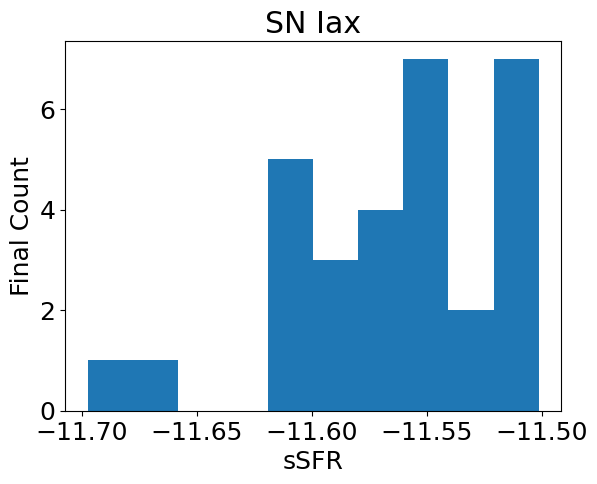

In [139]:
plt.hist(passive_iax)
plt.xlabel("sSFR")
plt.ylabel("Final Count")
plt.title("SN Iax")

(array([2., 0., 0., 0., 7., 3., 6., 3., 3., 6.]),
 array([2.0068181e-12, 2.1214096e-12, 2.2360011e-12, 2.3505928e-12,
        2.4651843e-12, 2.5797758e-12, 2.6943673e-12, 2.8089588e-12,
        2.9235505e-12, 3.0381420e-12, 3.1527335e-12], dtype=float32),
 <BarContainer object of 10 artists>)

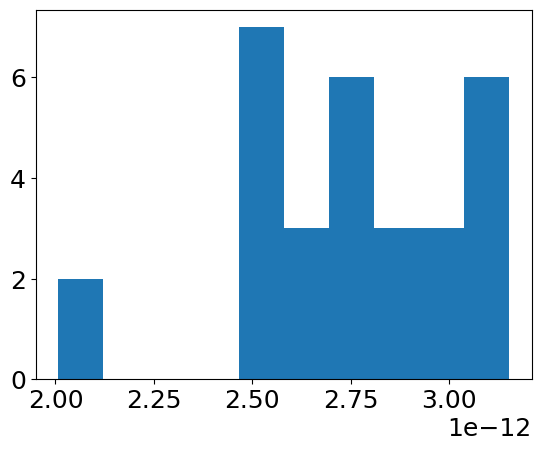

In [140]:
plt.hist(ssfr_iax.loc[(np.log10(ssfr_iax)<-11.5)])

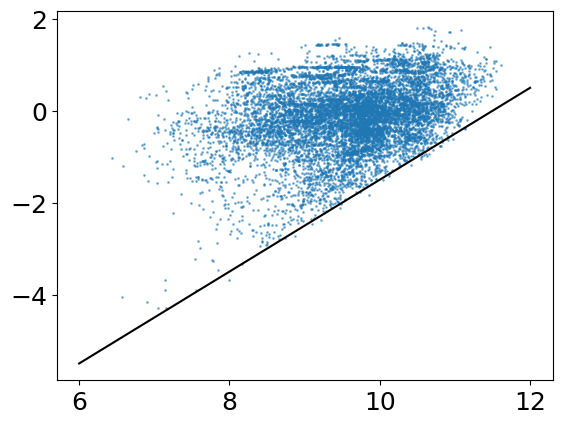

In [141]:
plt.scatter(mass_iax, sfr_iax, s=1, alpha=.5)
x = np.arange(6,13)

y = -11.5+x
plt.plot(x, y, 'k')

In [142]:
sn91bg   = collect_snana_outputs(path+"MLAG_SCOTCH10k_SNIa-91bg/")

In [143]:
sfr,mass = sn91bg['SIM_HOSTLIB(LOG_SFR)'], sn91bg['SIM_HOSTLIB(LOGMASS_TRUE)']
ssfr = 10**sfr/10**mass
active  = np.log10(ssfr[(np.log10(ssfr)>-11.5)])

In [144]:
len(active)/len(ssfr)*100

25.61

Text(0.5, 1.0, 'SN 91bg')

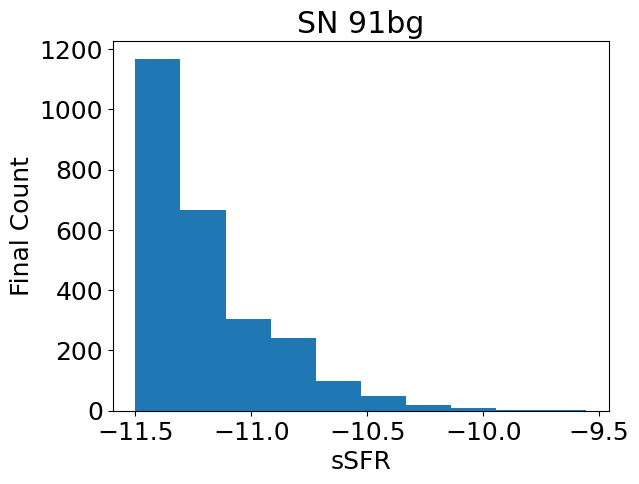

In [145]:
plt.hist(active)
plt.xlabel("sSFR")
plt.ylabel("Final Count")
plt.title("SN 91bg")

(array([3.53472244e-03, 7.67491001e-05, 1.42127963e-05, 8.52767778e-06,
        1.42127963e-06, 0.00000000e+00, 0.00000000e+00, 1.42127963e-06,
        1.42127963e-06, 1.42127963e-06]),
 array([  31.62612316,  306.35916178,  581.0922004 ,  855.82523902,
        1130.55827764, 1405.29131626, 1680.02435488, 1954.7573935 ,
        2229.49043211, 2504.22347073, 2778.95650935]),
 <BarContainer object of 10 artists>)

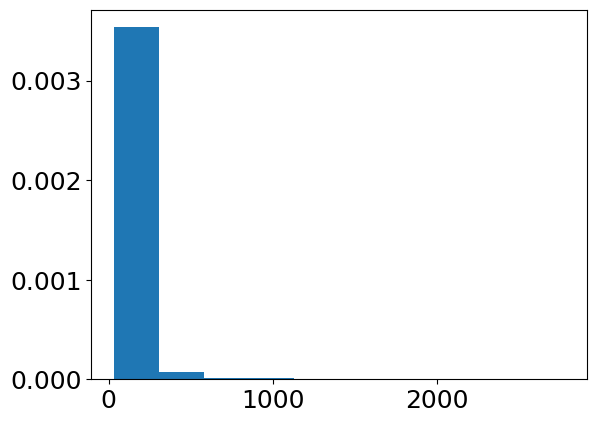

In [146]:
plt.hist(ssfr.loc[(np.log10(ssfr)>-11.5)]*10**13, density=True)
# plt.hist(ssfr_iax.loc[(np.log10(ssfr_iax)<-11.5)]*10**13, density=True)

In [147]:
max(ssfr)

2.7789565093527813e-10

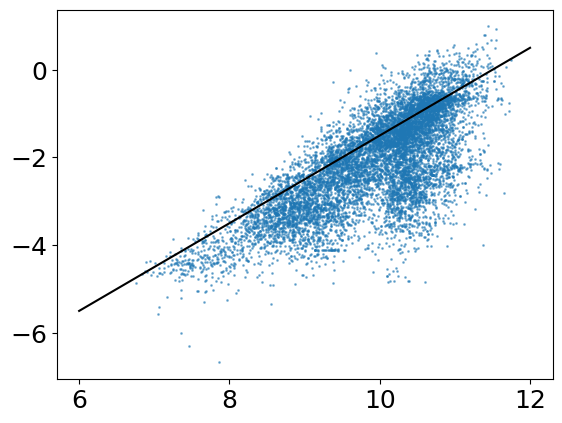

In [148]:
plt.scatter(mass, sfr, s=1, alpha=.5)
x = np.arange(6,13)
y = -11.5+x
plt.plot(x, y, 'k')

In [149]:
# set plot settings

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 18})

In [150]:
# get DES supernova data

In [151]:
sndes = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DES3YR.csv", delim_whitespace=True)

In [152]:
sndes

,TRANSIENT_NAME,SNID,ZHD,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_I,MAG_I_ERR,MAG_Z,MAG_Z_ERR,LOG_MSTELLAR,LOG_MSTELLAR_ERR,LOG_sSFR,PHOTO_CATALOGUE
0,DES13C3dgs,1248677,0.3502,21.80,0.01,21.04,0.01,20.81,0.01,20.59,0.01,9.57,0.03,-8.48,W19
1,DES13S1qv,1250017,0.1817,22.17,0.01,21.60,0.01,21.37,0.01,21.25,0.01,8.78,0.05,-8.69,W19
2,DES13C1hwx,1253039,0.4535,24.01,0.04,23.04,0.02,22.56,0.03,22.36,0.03,9.39,0.07,-9.91,W19
3,DES13E1goh,1253101,0.4596,25.48,0.11,24.32,0.05,24.22,0.07,23.81,0.06,8.57,0.08,-8.68,W19
4,DES13C1juw,1253920,0.1956,22.18,0.01,21.13,0.01,20.68,0.01,20.53,0.01,9.43,0.04,-14.40,W19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,DES15X1oqk,1345594,0.4224,21.11,0.01,19.59,0.01,19.00,0.01,18.63,0.01,11.14,0.06,-9.97,W19
202,DES15C1olp,1346137,0.3635,21.29,0.01,20.49,0.01,20.25,0.01,19.91,0.01,9.89,0.03,-8.76,W19
203,DES15C3omh,1346387,0.3445,24.60,0.13,23.33,0.05,22.63,0.03,23.01,0.09,9.04,0.08,-12.48,W19
204,DES15C2oxn,1346956,0.3335,27.02,0.21,26.51,0.16,26.54,0.23,26.29,0.32,6.90,0.25,-8.19,W19


In [153]:
logm_des    = sndes['LOG_MSTELLAR']
logssfr_des = sndes['LOG_sSFR']
logsfr_des  = np.log10(10**logssfr_des*10**logm_des)

In [154]:
ls /global/cscratch1/sd/kessler/SNANA_LSST_SIM/HLIB_WGTMAP_TESTS/

MLAG_SCOTCH_ZLIM_SNIa-SALT2_10k_HOST+WGT/
MLAG_SCOTCH_ZLIM_SNIa-SALT2_10k_NOWGT/
MLAG_SCOTCH_ZLIM_SNIa-SALT2_10k_RANDHOST/


In [155]:
path = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/HLIB_WGTMAP_TESTS/"
hosts_hostlib_wgt   = collect_snana_outputs(path+"MLAG_SCOTCH_ZLIM_SNIa-SALT2_10k_HOST+WGT/")
hosts_hostlib_nowgt = collect_snana_outputs(path+"MLAG_SCOTCH_ZLIM_SNIa-SALT2_10k_NOWGT/")
hosts_randlib_wgt   = collect_snana_outputs(path+"MLAG_SCOTCH_ZLIM_SNIa-SALT2_10k_RANDHOST/")

In [156]:
hw_idx  = hosts_hostlib_wgt['HOSTGAL_OBJID']
hnw_idx = hosts_hostlib_nowgt['HOSTGAL_OBJID']
rw_idx  = hosts_randlib_wgt['HOSTGAL_OBJID']
quantities = ['Mag_true_r_sdss_z0', 'Mag_true_g_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0']
absmag_hw  = pull_cosmodc2_props(quantities, hw_idx)
absmag_hnw = pull_cosmodc2_props(quantities, hnw_idx)
absmag_rw  = pull_cosmodc2_props(quantities, rw_idx)

9556
9558
9559
9560
9683
9684
9685
9686
9687
9688
9812
9813
9814
9815
9816
9940
9941
9942
9943
9944
10068
10069
10070
10071
10072
10195
10196
10197
10198
10199
9556
9558
9559
9560
9683
9684
9685
9686
9687
9688
9812
9813
9814
9815
9816
9940
9941
9942
9943
9944
10068
10069
10070
10071
10072
10195
10196
10197
10198
10199
9556
9558
9559
9560
9683
9684
9685
9686
9687
9688
9812
9813
9814
9815
9816
9940
9941
9942
9943
9944
10068
10069
10070
10071
10072
10195
10196
10197
10198
10199


In [157]:
u_hw,g_hw,r_hw,i_hw,z_hw,ellip_hw,rshift_hw,gr_hw,iz_hw,logmass_hw,sfr_hw = snhost_props(hosts_hostlib_wgt)
u_hnw,g_hnw,r_hnw,i_hnw,z_hnw,ellip_hnw,rshift_hnw,gr_hnw,iz_hnw,logmass_hnw,sfr_hnw = snhost_props(hosts_hostlib_nowgt)
u_rw,g_rw,r_rw,i_rw,z_rw,ellip_rw,rshift_rw,gr_rw,iz_rw,logmass_rw,sfr_rw = snhost_props(hosts_randlib_wgt)

In [158]:
hostlib = pd.read_csv("/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/70cosmo/SNIa_GHOST.HOSTLIB_shift_70cosmo_DROPNBR.gz", sep=' ', header=10)

In [159]:
hostlib

,VARNAMES:,GALID,ZORIG,RA_GAL,DEC_GAL,ZTRUE,u_obs,u_obs_err,g_obs,g_obs_err,...,ZPHOT_Q070,ZPHOT_Q080,ZPHOT_Q090,ZPHOT_Q100,logP50,IQR,ZPHOT,ZPHOT_ERR,IQR_ZPHOT,P_ZPHOT
0,GAL:,10325026963,2.014483,55.1711,-43.3998,2.0776,99.0000,9.0000,25.9055,0.0941,...,2.08998,2.10938,2.13629,2.55488,10.3676,0.0509,2.05791,0.08250,0.08250,6.52311
1,GAL:,10313149058,0.601482,55.1569,-43.3939,0.6169,99.0000,9.0000,26.4334,0.1499,...,0.68783,0.69843,0.71313,0.94177,19.6284,0.0269,0.67032,0.04506,0.04506,11.94212
2,GAL:,10318102353,1.521414,55.1392,-43.3799,1.5754,26.8400,0.3463,26.8057,0.1484,...,1.63462,1.65116,1.67410,2.03100,12.2350,0.0432,1.60728,0.07034,0.07034,7.65056
3,GAL:,10312580850,0.279931,55.1451,-43.3751,0.3260,24.8842,0.1464,23.1108,0.0082,...,0.34660,0.35506,0.36678,0.54920,23.6587,0.0223,0.33263,0.03595,0.03595,14.96827
4,GAL:,10314224210,0.894043,55.1151,-43.3690,0.9379,99.0000,9.0000,99.0000,9.0000,...,0.91863,0.93068,0.94738,1.20729,16.0059,0.0330,0.89872,0.05123,0.05123,10.50557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2141265,GAL:,9875004684,0.121452,69.9896,-39.6490,0.0283,21.6949,0.0100,20.0114,0.0050,...,0.02574,0.03117,0.03906,0.17444,30.9016,0.0171,0.01744,0.01955,0.01955,26.98312
2141266,GAL:,9937504892,0.105262,73.1359,-39.2633,0.0400,19.2653,0.0052,17.9961,0.0050,...,0.06506,0.07173,0.08099,0.22519,30.5107,0.0173,0.05405,0.02826,0.02826,19.02661
2141267,GAL:,9937500004,0.023221,73.2106,-39.1693,0.0469,16.3390,0.0050,14.7361,0.0050,...,0.05545,0.06202,0.07116,0.21389,29.9033,0.0177,0.04464,0.02762,0.02762,19.43232
2141268,GAL:,9937505018,0.109625,72.9583,-39.1352,0.0472,22.1994,0.0145,20.6150,0.0051,...,0.05232,0.05884,0.06793,0.21013,30.4668,0.0173,0.04160,0.02730,0.02730,19.63596


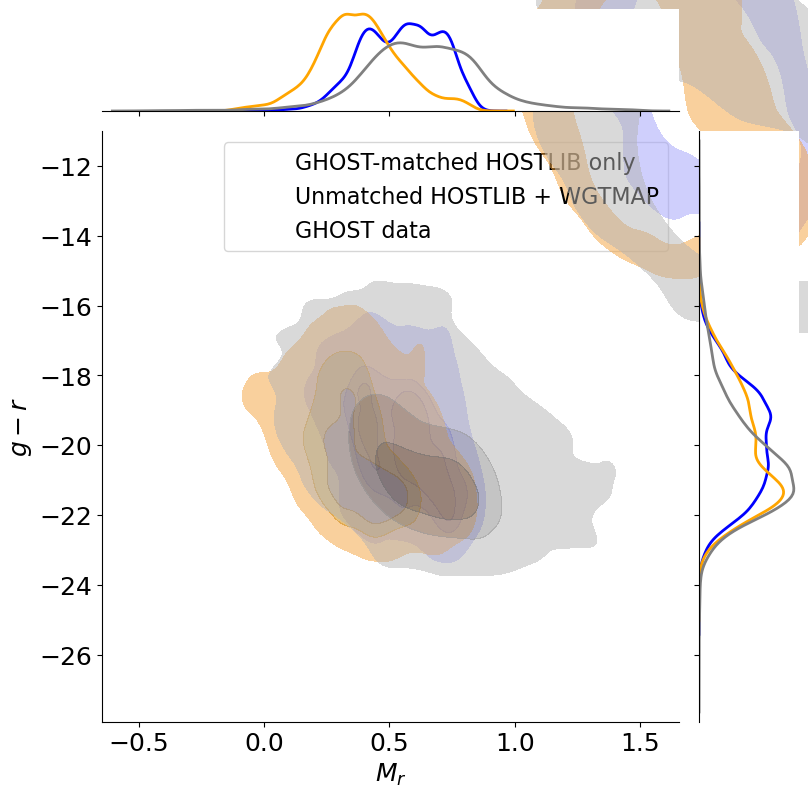

In [160]:
g = sns.JointGrid(height=8)
x, y = absmag_hnw['Mag_true_g_sdss_z0']-absmag_hnw['Mag_true_r_sdss_z0'], absmag_hnw['Mag_true_r_sdss_z0']
sns.kdeplot(x=x, y=y, color="b", ax=g.ax_joint, label='GHOST-matched HOSTLIB only', levels=4, fill=True, alpha=.5)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='blue')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='blue')


x2, y2 = absmag_rw['Mag_true_g_sdss_z0']-absmag_rw['Mag_true_r_sdss_z0'], absmag_rw['Mag_true_r_sdss_z0']
sns.kdeplot(x=x2, y=y2, color="orange", ax=g.ax_joint, label='Unmatched HOSTLIB + WGTMAP', levels=4, fill=True, alpha=.5)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y2, linewidth=2, ax=g.ax_marg_y, color='orange')
sns.kdeplot(x=x2, linewidth=2, ax=g.ax_marg_x, color='orange')

x3, y3 = g_gr, gR
sns.kdeplot(x=x3, y=y3, color="gray", ax=g.ax_joint, label='GHOST data', levels=4, fill=True, alpha=.5)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='gray')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='gray')
# plt.legend()
legend_properties = {'size':16}

g.ax_joint.legend(prop=legend_properties)
g.set_axis_labels("$M_r$", "$g-r$")


In [162]:
des_r_lim  = 23.8
deslim_hw  = r_hw<23.8
deslim_hnw = r_hnw<23.8
deslim_rw  = r_rw<23.8


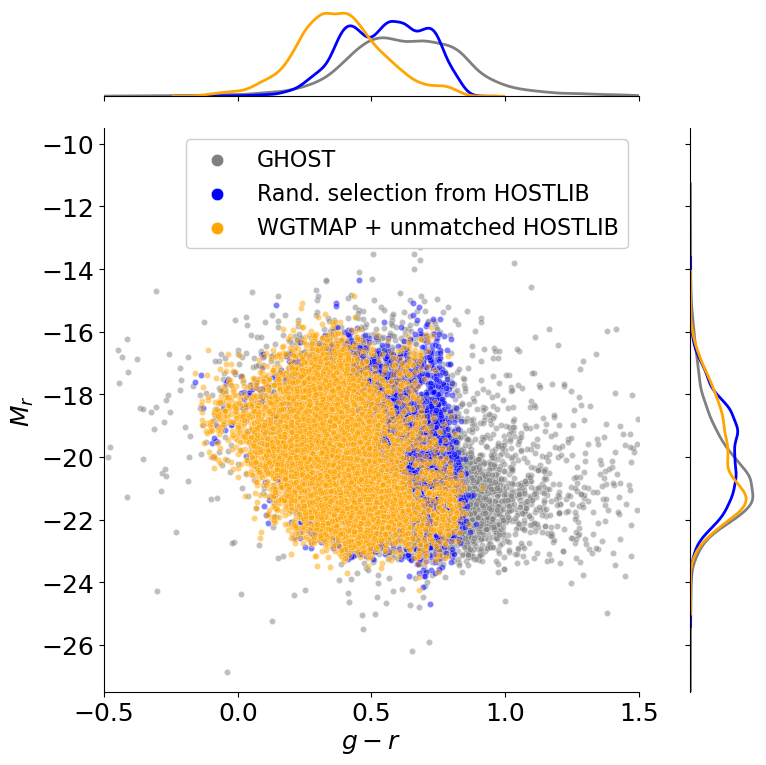

In [248]:
g = sns.JointGrid(height=8, xlim=[-.5, 1.5], ylim=[-27.5,-9.5])

s = 20
alpha=.5
x3, y3 = g_gr, gR
sns.scatterplot(x=x3, y=y3, color="gray", s=s, alpha=alpha, ax=g.ax_joint, label='GHOST')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='gray')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='gray')
# plt.legend()
legend_properties = {'size':16}

x, y = absmag_hnw['Mag_true_g_sdss_z0']-absmag_hnw['Mag_true_r_sdss_z0'], absmag_hnw['Mag_true_r_sdss_z0']
sns.scatterplot(x=x, y=y, color="b", s=s, alpha=alpha, ax=g.ax_joint, label='Rand. selection from HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='blue')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='blue')

x2, y2 = absmag_rw['Mag_true_g_sdss_z0']-absmag_rw['Mag_true_r_sdss_z0'], absmag_rw['Mag_true_r_sdss_z0']
sns.scatterplot(x=x2, y=y2, color="orange", s=s, alpha=alpha, ax=g.ax_joint, label='WGTMAP + unmatched HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y2, linewidth=2, ax=g.ax_marg_y, color='orange')
sns.kdeplot(x=x2, linewidth=2, ax=g.ax_marg_x, color='orange')

leg = g.ax_joint.legend(prop=legend_properties, framealpha=1, markerscale=2)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

g.set_axis_labels("$g-r$", "$M_r$")
plt.tight_layout()
plt.savefig("../../plots/snia-color-mag-incomplete-runs.png")


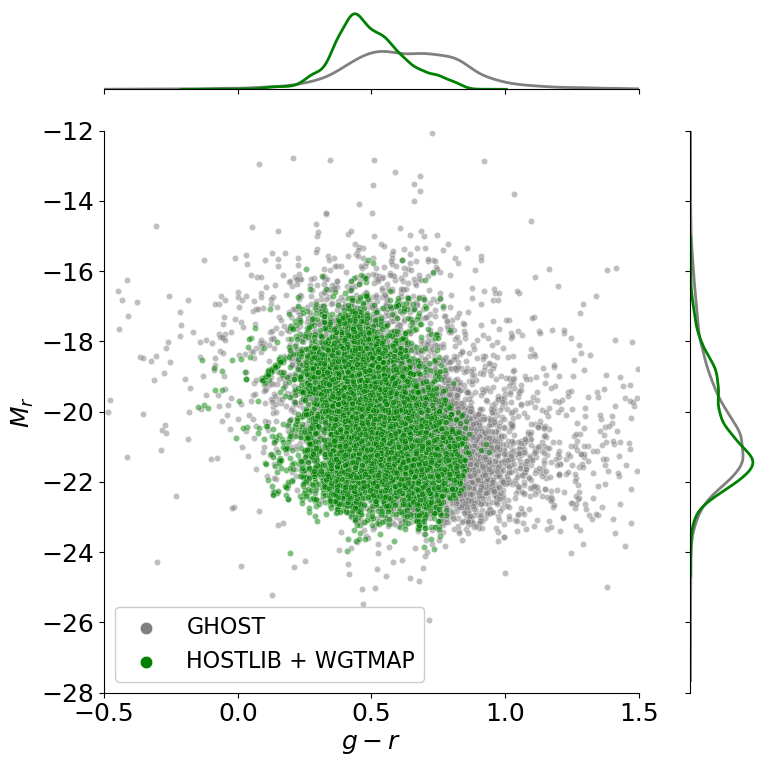

In [252]:
g = sns.JointGrid(height=8, xlim=[-0.5,1.5], ylim=[-28,-12])

x3, y3 = g_gr, gR
sns.scatterplot(x=x3, y=y3, color="gray", s=s, alpha=alpha, ax=g.ax_joint, label='GHOST')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='gray')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='gray')
# plt.legend()
legend_properties = {'size':16}

x, y = absmag_hw['Mag_true_g_sdss_z0']-absmag_hw['Mag_true_r_sdss_z0'], absmag_hw['Mag_true_r_sdss_z0']
sns.scatterplot(x=x, y=y, color="green", s=s, alpha=alpha, ax=g.ax_joint, label='HOSTLIB + WGTMAP')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='green')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='green')

leg = g.ax_joint.legend(prop=legend_properties, framealpha=1, markerscale=2)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

g.set_axis_labels("$g-r$", "$M_r$")
plt.tight_layout()
plt.savefig("../../plots/snia-color-mag-complete-runs.png")


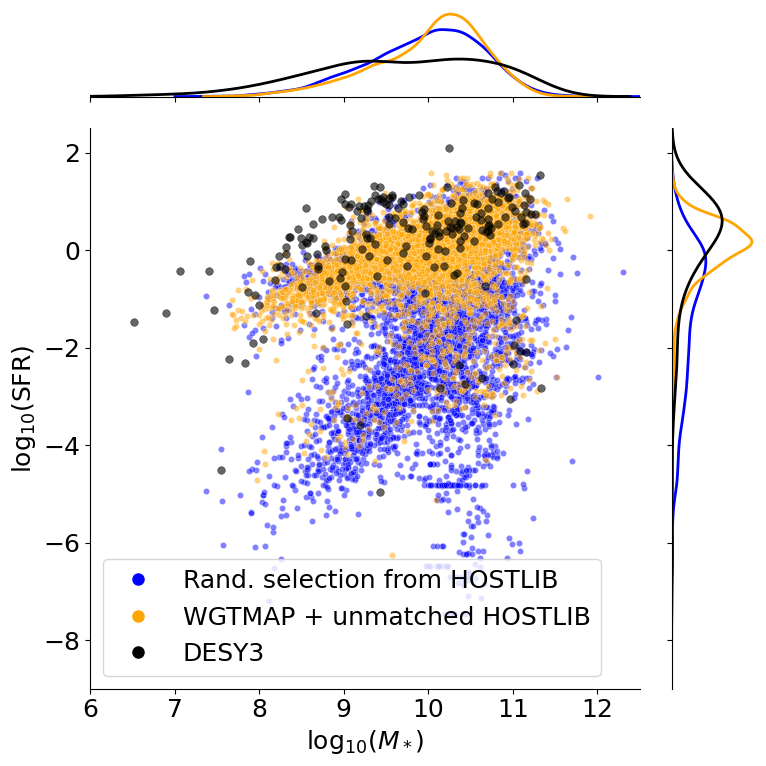

In [242]:
g = sns.JointGrid(height=8, xlim=[6,12.5], ylim=[-9,2.5])

x2, y2 = logmass_hnw.to_numpy()[deslim_hnw], sfr_hnw.to_numpy()[deslim_hnw]
sns.scatterplot(x=x2, y=y2, color="b", s=s, alpha=alpha, ax=g.ax_joint, label='Rand. selection, SNIa HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y2, linewidth=2, ax=g.ax_marg_y, color='blue')
sns.kdeplot(x=x2, linewidth=2, ax=g.ax_marg_x, color='blue')

x3, y3 = logmass_rw.to_numpy()[deslim_rw], sfr_rw.to_numpy()[deslim_rw]
sns.scatterplot(x=x3, y=y3, color="orange", s=s, alpha=alpha, ax=g.ax_joint, label='SNIa WGTMAP + unmatched HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='orange')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='orange')

x, y = logm_des, logsfr_des
sns.scatterplot(x=x, y=y, color="black", ec='black', s=30, alpha=.6, ax=g.ax_joint, label='SNIa hosts, DES')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='k')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='k')
# plt.legend()
legend_properties = {'size':16}

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', linestyle='none',color='blue', alpha=1, label='Rand. selection from HOSTLIB',
                 markersize=8),
    Line2D([0], [0], marker='o', alpha=1, color='orange', label='WGTMAP + unmatched HOSTLIB',linestyle='none',
                 markersize=8),
Line2D([0], [0], marker='o', color='black', alpha=1, label='DESY3',linestyle='none',
                  markersize=8)]

g.ax_joint.legend(handles=legend_elements, loc='lower left')

g.set_axis_labels("$\log_{10}(M_*)$", "$\log_{10}(\mathrm{SFR})$")
plt.tight_layout()
plt.savefig("../../plots/snia-sfr-m-incomplete-runs.png")


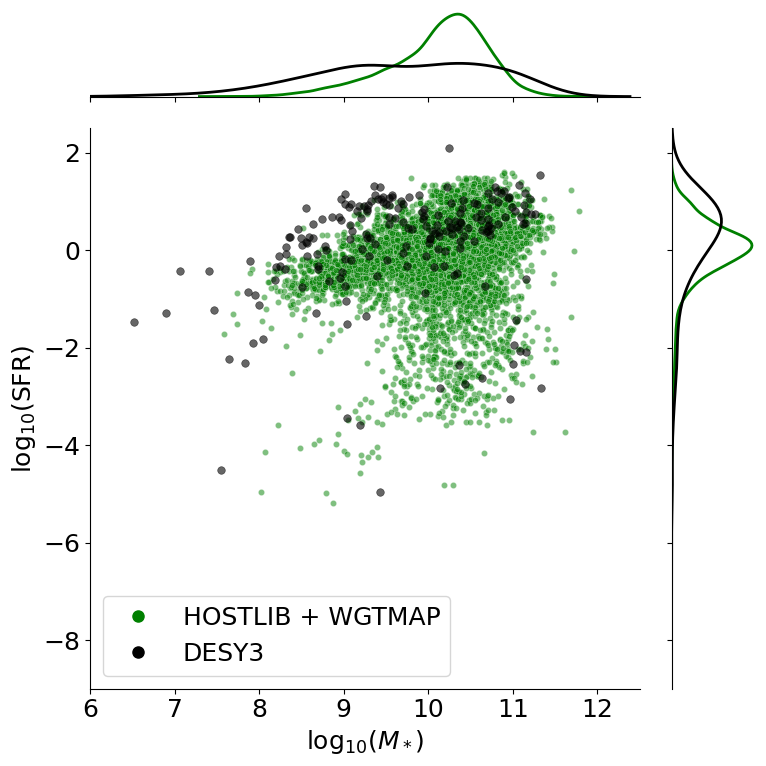

In [251]:
g = sns.JointGrid(height=8, xlim=[6,12.5], ylim=[-9,2.5])

x3, y3 = logmass_hw.to_numpy()[deslim_hw], sfr_hw.to_numpy()[deslim_hw]
sns.scatterplot(x=x3, y=y3, color="green", s=s, alpha=alpha, ax=g.ax_joint, label='HOSTLIB + WGTMAP')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='green')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='green')

x, y = logm_des, logsfr_des
sns.scatterplot(x=x, y=y, color="black", ec='black', s=30, alpha=.6, ax=g.ax_joint, label='DESY3')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='k')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='k')
# plt.legend()
legend_properties = {'size':16}

legend_elements = [Line2D([0], [0], marker='o', linestyle='none',color='green', alpha=1, label='HOSTLIB + WGTMAP',
                 markersize=8),
Line2D([0], [0], marker='o', color='black', alpha=1, label='DESY3',linestyle='none',
                  markersize=8)]

g.ax_joint.legend(handles=legend_elements, loc='lower left')

g.set_axis_labels("$\log_{10}(M_*)$", "$\log_{10}(\mathrm{SFR})$")
plt.tight_layout()
plt.savefig("../../plots/snia-sfr-m-complete-runs.png")

# Comparing u-r between SN Ia subclasses

In [ ]:
def gcr_pull():
    

In [67]:
absmag_hw['Mag_true_u_sdss_z0']-absmag_hw['Mag_true_r_sdss_z0']

2      0.580428
3      0.363236
9      0.758827
10     0.754372
13     0.361756
         ...   
214    0.847848
215    0.874358
216    0.786042
218    0.826413
220    0.888927
Name: REDSHIFT_FINAL, Length: 3752, dtype: float32

/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

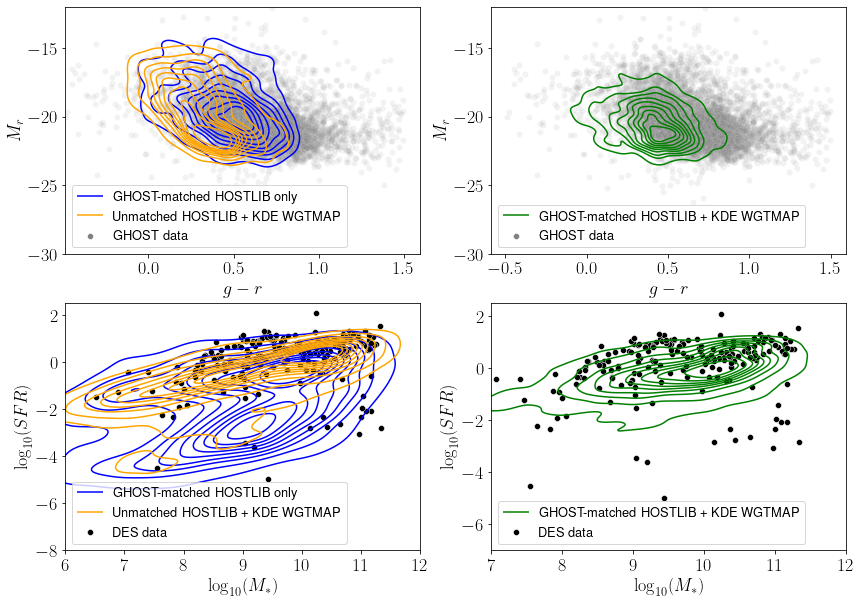

In [113]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[14,10])
sns.kdeplot(x=gr_hnw, y=R_hnw, ax=ax1, label='GHOST-matched HOSTLIB only', color='blue')
sns.kdeplot(x=gr_rw, y=R_rw, ax=ax1, label='Unmatched HOSTLIB + KDE WGTMAP', color='orange')
sns.scatterplot(g_gr, gR, ax=ax1, label='GHOST data', color='.5', alpha=.1)
leg1 = ax1.legend(fontsize=13)
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
ax1.set_ylim([-30,-12])
ax1.set_xlabel("$g-r$")
ax1.set_ylabel("$M_r$")

sns.kdeplot(x=gr_hw, y=R_hw, ax=ax2, label='GHOST-matched HOSTLIB + KDE WGTMAP', color='green')
sns.scatterplot(g_gr, gR, ax=ax2, label='GHOST data', color='.5', alpha=.1)
# sns.kdeplot(g_gr, gR,  label='GHOST data', color='grey')
leg2 = ax2.legend(fontsize=13)
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
ax2.set_ylim([-30,-12])
ax2.set_xlabel("$g-r$")
ax2.set_ylabel("$M_r$")

sns.kdeplot(x=logmass_hnw, y=sfr_hnw, ax=ax3, label='GHOST-matched HOSTLIB only', color='blue')
sns.kdeplot(x=logmass_rw, y=sfr_rw, ax=ax3, label='Unmatched HOSTLIB + KDE WGTMAP', color='orange')
sns.scatterplot(logm_des, logsfr_des, ax=ax3, label='DES data', color='k')
ax3.legend(fontsize=13)
ax3.set_ylim([-8,2.5])
ax3.set_xlim([6,12])
ax3.set_xlabel("$\log_{10}(M_*)$")
ax3.set_ylabel("$\log_{10}(SFR)$")

sns.kdeplot(x=logmass_hw, y=sfr_hw, ax=ax4, label='GHOST-matched HOSTLIB + KDE WGTMAP', color='green')
sns.scatterplot(logm_des, logsfr_des, ax=ax4, label='DES data', color='k')
ax4.legend(fontsize=13)
ax4.set_ylim([-7,2.5])
ax4.set_xlim([7,12])
ax4.set_xlabel("$\log_{10}(M_*)$")
ax4.set_ylabel("$\log_{10}(SFR)$")

plt.savefig("plots/snia_comparisons_hostlib_wgtmap.png")

/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\log_{10}(SFR)$')

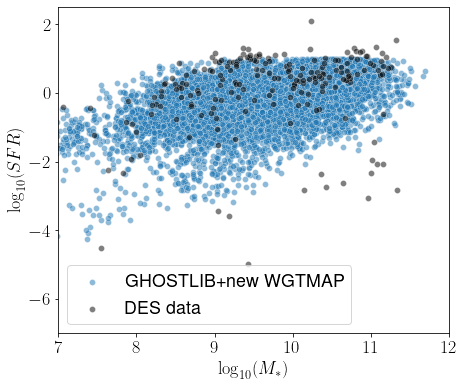

In [153]:
plt.figure(figsize=[7,6])

# sns.scatterplot(x=logmass_hnw, y=sfr_hnw, alpha=.5, label='GHOSTLIB only')
sns.scatterplot(x=logmass_hw, y=sfr_hw, alpha=.5, label='GHOSTLIB+new WGTMAP')
# sns.scatterplot(x=logmass_rw, y=sfr_rw, alpha=.5, label='Random HOSTLIB+WGTMAP')
sns.scatterplot(logm_des, logsfr_des, alpha=.5, label='DES data', color='k')
plt.legend()
plt.ylim([-7,2.5])
plt.xlim([7,12])
plt.xlabel("$\log_{10}(M_*)$")
plt.ylabel("$\log_{10}(SFR)$")